In [1]:
import xarray as xr
import numpy as np
import os

# 1. 路径设置 (保持你之前的路径)
file_path = r'../data_generators/dataset_yrd.nc'

# 2. 读取数据
ds = xr.open_dataset(file_path)

# --- A. 基础信息输出 ---
print("=== 维度信息 ===")
print(f"时间维度 (time): {ds.sizes['time']}")
print(f"站点维度 (station): {ds.sizes['station']}")

# 获取所有变量名 (PM2.5, O3, t2m, etc.)
var_names = list(ds.data_vars)
print(f"\n包含的变量: {var_names}")


# 如果你想把所有变量堆叠成一个大数组用于训练模型
all_data_list = []
for var in var_names:
    all_data_list.append(ds[var].values)

# stack 堆叠: axis=-1 表示在最后一个维度增加变量维
# 结果形状: (70128, 127, 10)
full_time_series_array = np.stack(all_data_list, axis=-1)

print(f"\n=== 最终合并的时间序列数组 ===")
print(f"Shape: {full_time_series_array.shape}")
print("含义: (时间步, 站点数, 特征变量数)")
print(f"其中特征顺序对应: {var_names}")

ds.close()

=== 维度信息 ===
时间维度 (time): 70128
站点维度 (station): 127

包含的变量: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']

=== 最终合并的时间序列数组 ===
Shape: (70128, 127, 10)
含义: (时间步, 站点数, 特征变量数)
其中特征顺序对应: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']


# 数据展示

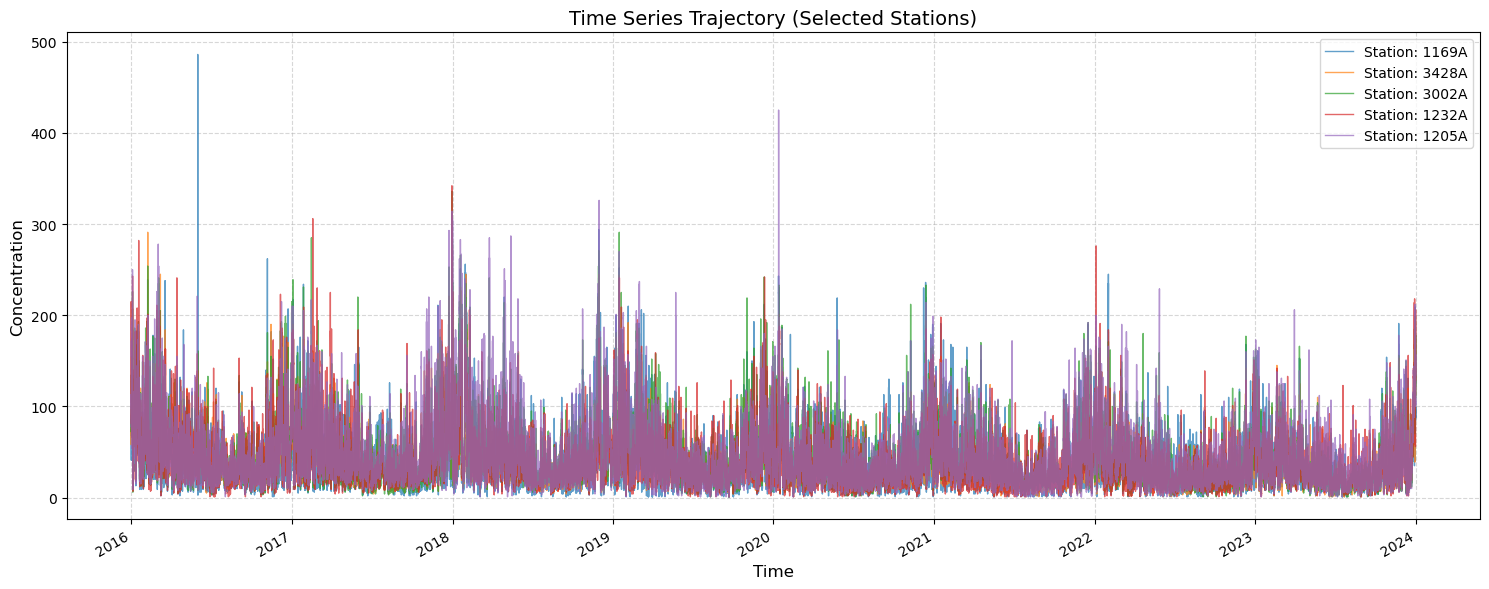

In [2]:
import matplotlib.pyplot as plt

num_stations_to_plot = 5
pm25 = ds['PM2.5']
o3 = ds['O3']
times = ds['time'].values
stations = ds['station'].values

np.random.seed(42)
selected_indices = np.random.choice(len(stations), num_stations_to_plot, replace=False)

# # 方式 B: 手动指定前几个站点 (比较稳定，适合观察)
# selected_indices = [0, 10, 20] # 比如第1个、第11个、第21个站点

# 创建画布
plt.figure(figsize=(15, 6))

# 循环绘制选定站点的曲线
for idx in selected_indices:
    station_name = stations[idx]
    # 提取该站点的 PM2.5 数据
    # .isel(station=idx) 按索引取
    station_data_o3 = o3.isel(station=idx).values
    station_data_pm25 = pm25.isel(station=idx).values
    
    plt.plot(times, station_data_pm25, label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# 添加图表细节
plt.title('Time Series Trajectory (Selected Stations)', fontsize=14)
plt.ylabel('Concentration', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 优化时间轴显示 (防止重叠)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# 算法处理

In [3]:
import sys
import os
sys.path.append(os.path.abspath('..')) 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools.tools import get_positive_contributions, compute_entropy, print_equations, fit_sindy_sr3_robust, lift_time_delay, plot_station
from tools.tools import split_and_group_matrices, plot_macro_serie
import warnings
from sklearn.exceptions import ConvergenceWarning

# 仅忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
x_data = np.column_stack((pm25.values, o3.values))
df = pd.read_csv('../data_generators/stations_yrd.csv')
micro_name0 = list(df["station_id"]) * 2
micro_name1 = ['_pm25'] * 127 + ['_o3'] * 127
micro_name = [a + b for a, b in zip(micro_name0, micro_name1)]
x_data.shape

(70128, 254)

In [5]:
ide = ps.IdentityLibrary()
n_delays = 2
delay_interval = 24
H, new_names = lift_time_delay(x_data, feature_names=micro_name, n_delays=n_delays, delay_interval=delay_interval)
H.shape, new_names

((70080, 762),
 ['1141A_pm25',
  '1142A_pm25',
  '1143A_pm25',
  '1144A_pm25',
  '1145A_pm25',
  '1147A_pm25',
  '1148A_pm25',
  '1149A_pm25',
  '1150A_pm25',
  '1151A_pm25',
  '1152A_pm25',
  '1153A_pm25',
  '1154A_pm25',
  '1155A_pm25',
  '1156A_pm25',
  '1157A_pm25',
  '1158A_pm25',
  '1159A_pm25',
  '1160A_pm25',
  '1162A_pm25',
  '1163A_pm25',
  '1164A_pm25',
  '1165A_pm25',
  '1166A_pm25',
  '1167A_pm25',
  '1168A_pm25',
  '1169A_pm25',
  '1170A_pm25',
  '1171A_pm25',
  '1172A_pm25',
  '1186A_pm25',
  '1188A_pm25',
  '1189A_pm25',
  '1190A_pm25',
  '1191A_pm25',
  '1192A_pm25',
  '1193A_pm25',
  '1194A_pm25',
  '1195A_pm25',
  '1196A_pm25',
  '1200A_pm25',
  '1201A_pm25',
  '1203A_pm25',
  '1204A_pm25',
  '1205A_pm25',
  '1206A_pm25',
  '1207A_pm25',
  '1209A_pm25',
  '1223A_pm25',
  '1224A_pm25',
  '1226A_pm25',
  '1227A_pm25',
  '1228A_pm25',
  '1230A_pm25',
  '1231A_pm25',
  '1232A_pm25',
  '1233A_pm25',
  '1234A_pm25',
  '1235A_pm25',
  '1236A_pm25',
  '1239A_pm25',
  '1240A_

In [8]:
discrete_time = True
dt = 1
thresholds = 2 * np.logspace(-8, 1, 2)
print(thresholds)
model, results = fit_sindy_sr3_robust(H, ide, new_names, penalty='l1', discrete_time=discrete_time, max_iter=300, thresholds=thresholds, metric='bic', tol=1e-4, nu=1)

[2.e-08 2.e+01]
开始使用 L1 范数扫描 2 个参数...


100%|██████████| 5/5 [35:53<00:00, 430.63s/it]



最佳模型 (bic) | Penalty: l1
Param (Thr/Lam): 2.000e+01
Test MSE: 9.5972e+01
Complexity: 34588
(1141A_pm25)[k+1] = 0.562 1141A_pm25[k] + 0.072 1143A_pm25[k] + 0.072 1145A_pm25[k] + 0.049 1147A_pm25[k] + 0.028 1148A_pm25[k] + 0.008 1164A_pm25[k] + 0.012 1166A_pm25[k] + 0.018 1167A_pm25[k] + 0.040 1169A_pm25[k] + 0.022 1171A_pm25[k] + -0.027 1233A_pm25[k] + 0.069 3265A_pm25[k] + 0.019 3266A_pm25[k] + 0.017 3268A_pm25[k] + 0.016 3270A_pm25[k] + 0.004 3273A_pm25[k]
(1142A_pm25)[k+1] = 0.642 1142A_pm25[k] + 0.056 1143A_pm25[k] + 0.110 1145A_pm25[k] + 0.007 1147A_pm25[k] + 0.031 1148A_pm25[k] + -0.005 1149A_pm25[k] + 0.039 1150A_pm25[k] + 0.020 1166A_pm25[k] + 0.036 1169A_pm25[k] + 0.018 1171A_pm25[k] + 0.022 3265A_pm25[k] + 0.025 3266A_pm25[k]
(1143A_pm25)[k+1] = 0.018 1141A_pm25[k] + 0.642 1143A_pm25[k] + 0.125 1145A_pm25[k] + 0.034 1148A_pm25[k] + 0.021 1166A_pm25[k] + 0.041 1169A_pm25[k] + 0.009 1170A_pm25[k] + 0.046 1171A_pm25[k] + -0.025 1233A_pm25[k] + 0.036 3265A_pm25[k] + 0.036 3266A_p

In [7]:
for r in results:
    print('thr', r['thr'])
    print('lam', r['lam'])
    print('mse', r['mse'])
    print('score', r['score'])
    
model.score(H, t=dt)

thr 20.0
lam 20.0
mse 95.97201055739644
score 394214.47827529756
thr 2e-08
lam 2e-08
mse 97.40669975402852
score 5603261.46187186


0.9335436039342788

In [55]:
# model = results[0]['model']
# model.score(H, t=dt)

0.8213418250234797

In [8]:
step_pred = 5
t = range(step_pred)
init_data = H[0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,step_pred)
else:
    X_data_predicted = model.simulate(init_data,t) 

X_data_predicted.shape

(5, 762)

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_17733/2734313379.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


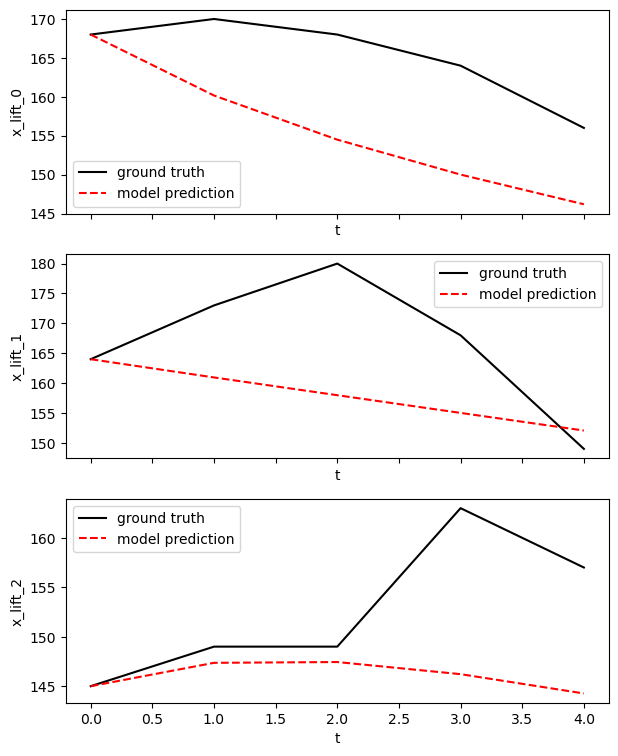

In [9]:
# 只看部分维度的多步预测
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(H[:step_pred, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:step_pred, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

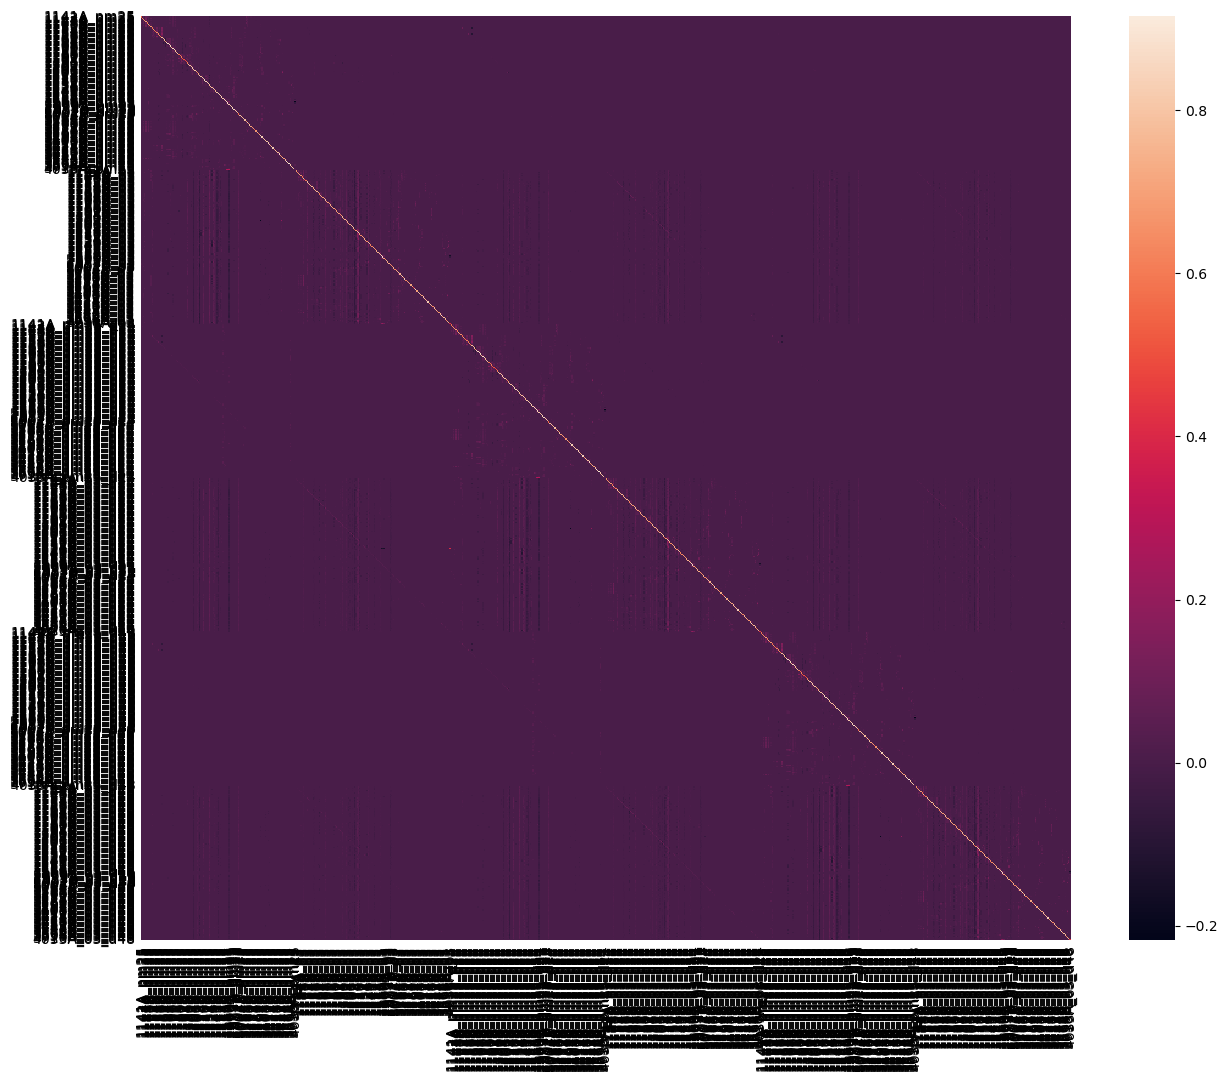

In [10]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=new_names, yticklabels=new_names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

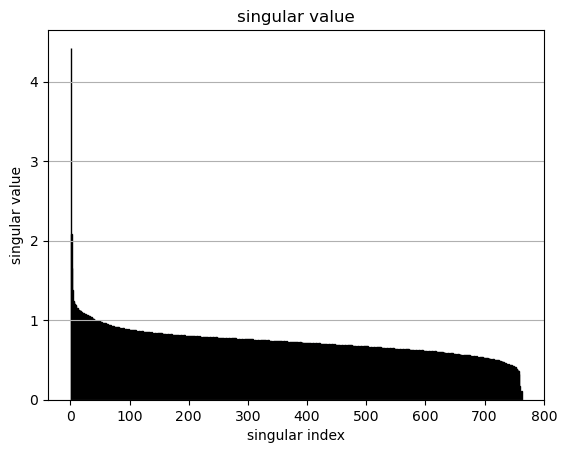

In [11]:
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

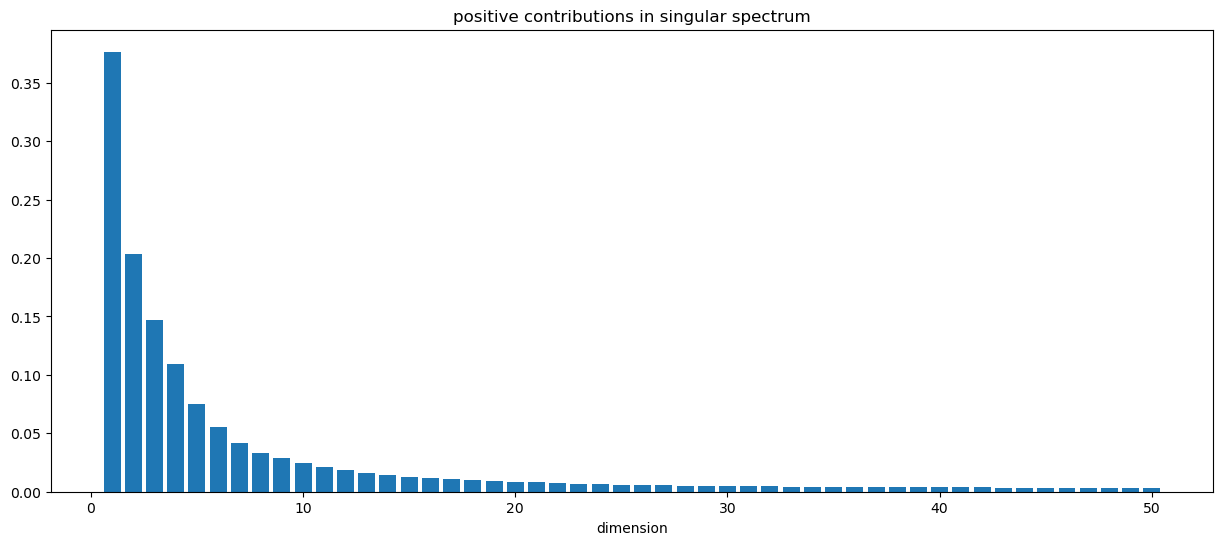

In [12]:
diff = get_positive_contributions(S)
diff = diff[:50]
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [13]:
print(compute_entropy(diff))

3.942484161651143


In [14]:
rank = 1
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

3.6916663157826157


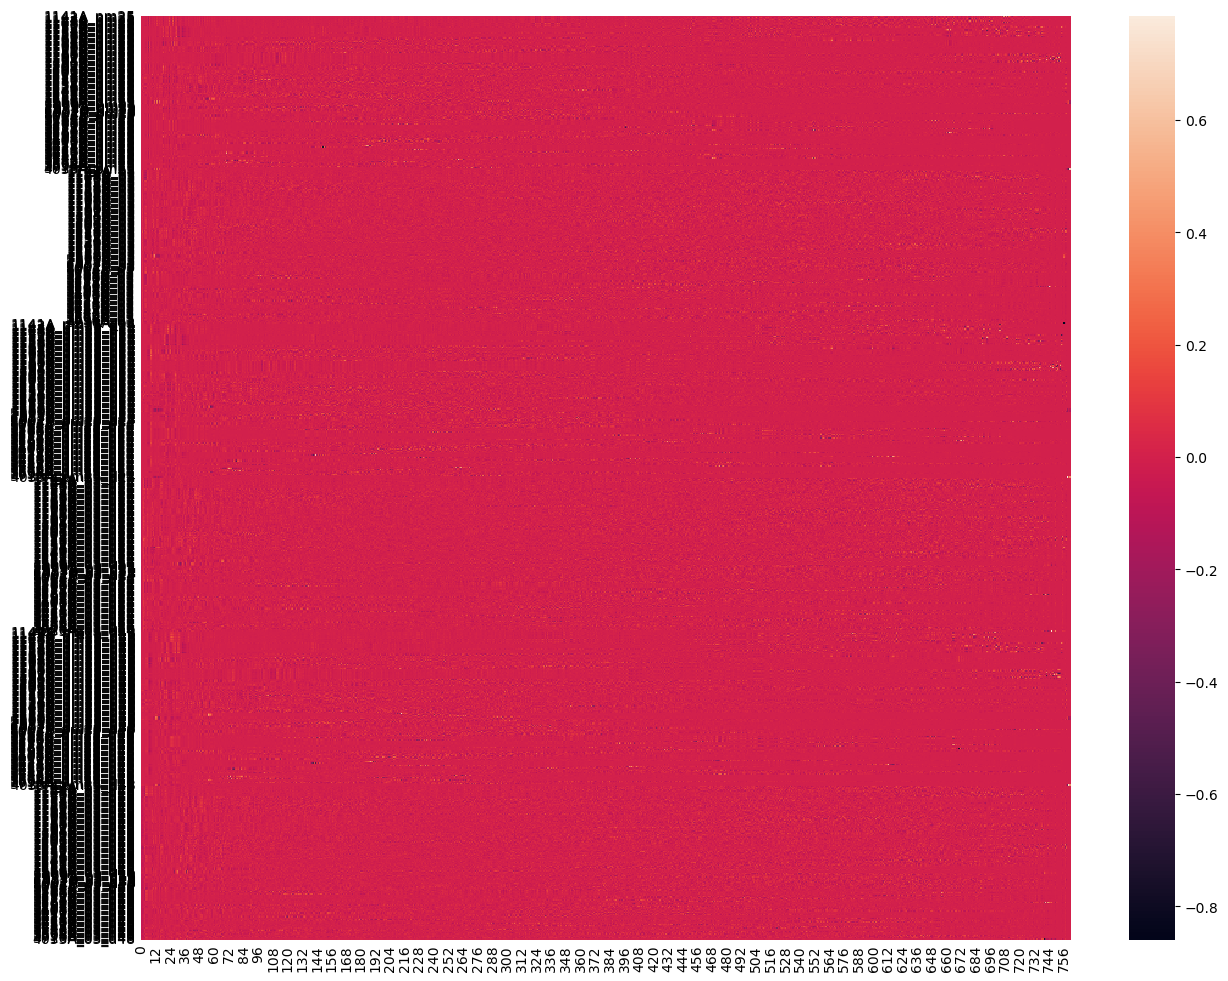

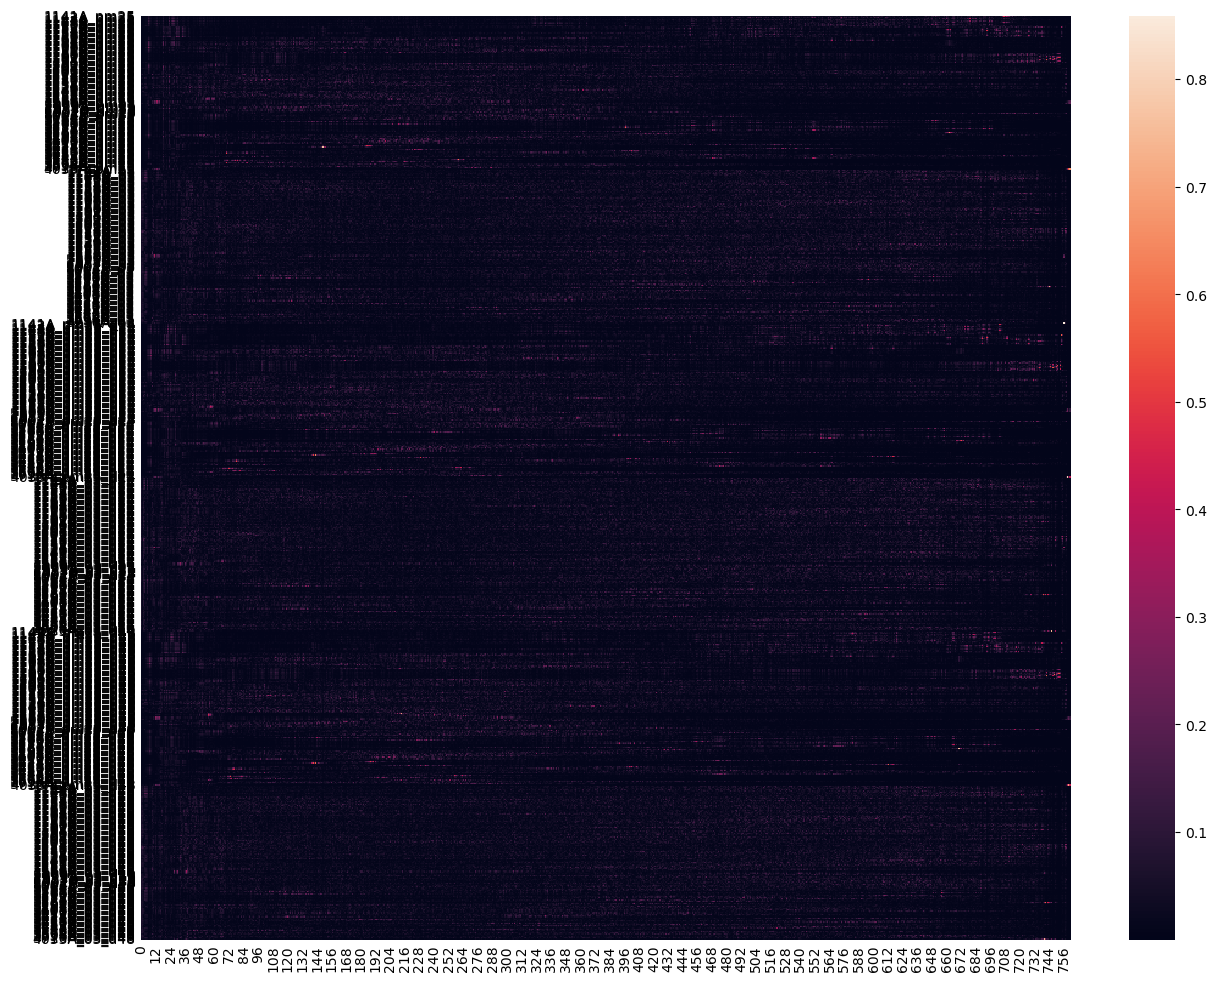

In [15]:
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=new_names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=new_names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

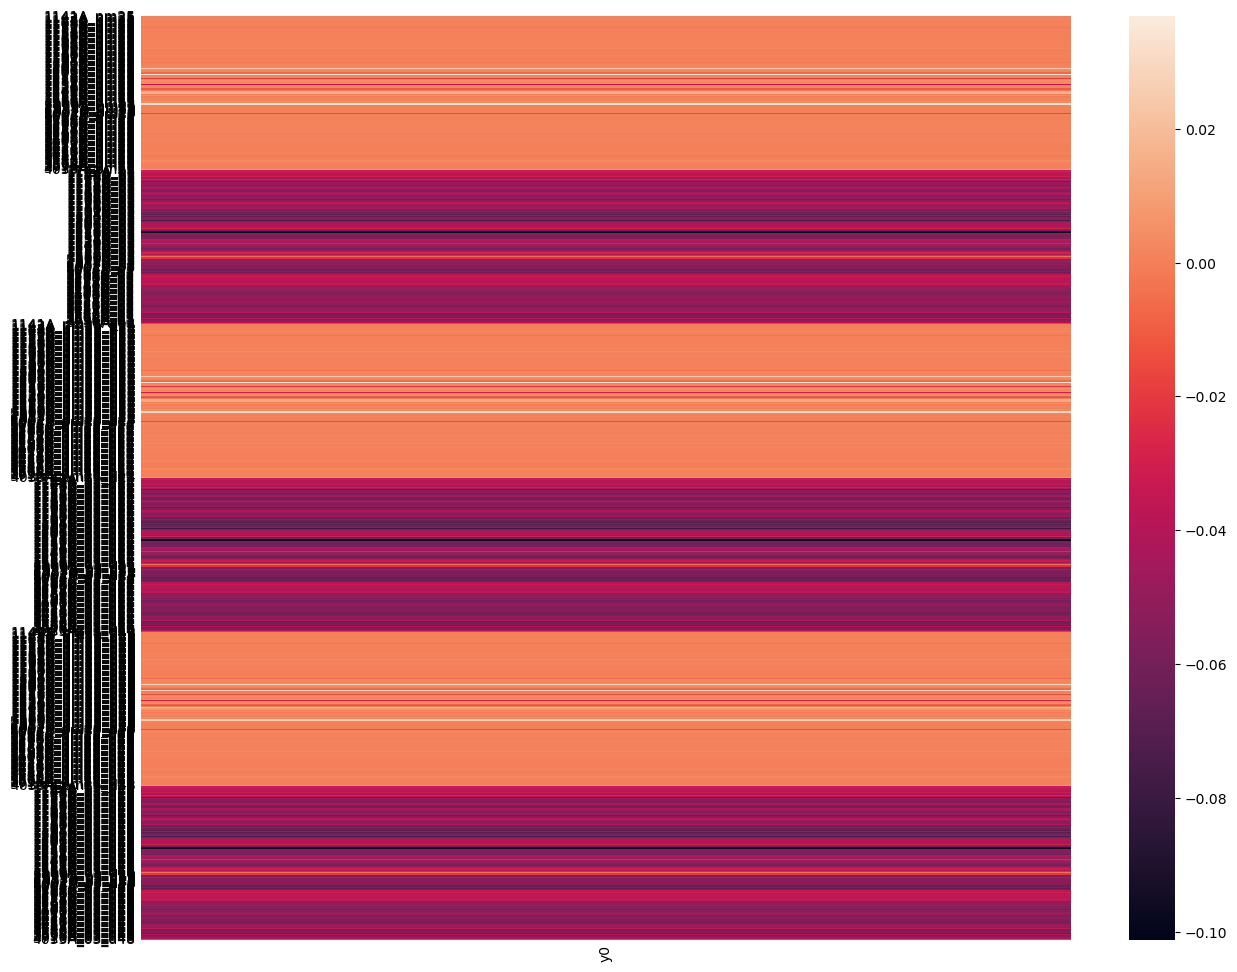

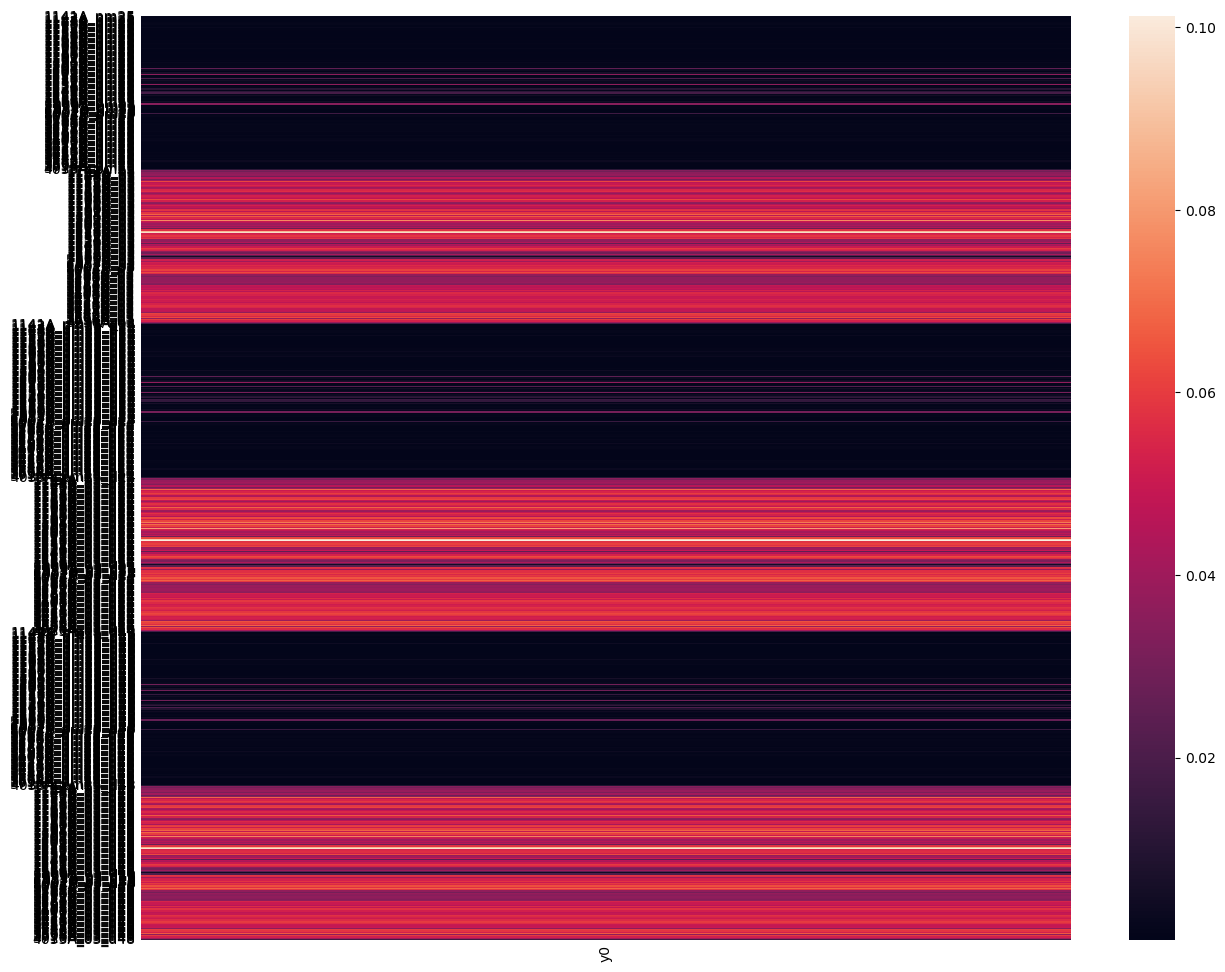

In [16]:
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=new_names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=new_names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [17]:
splits_pm25, splits_o3 = split_and_group_matrices(U_abs[:, :rank], new_names, n_delays+1)
len(splits_pm25)

3

In [18]:
print("PM2.5" + '-' * 120)
for i,cg in enumerate(splits_pm25):
    plot_station(df, cg, delay=i*delay_interval)

print("O3" + '-' * 120)
for i,cg in enumerate(splits_o3):
    plot_station(df, cg, delay=i*delay_interval)

PM2.5------------------------------------------------------------------------------------------------------------------------


O3------------------------------------------------------------------------------------------------------------------------


In [19]:
coarse_grain_coff = U_abs[:, :rank]
print_equations(coarse_grain_coff, new_names, macro_name)

y0 = 0.0012 * 1141A_pm25 + 0.0009 * 1143A_pm25 + 0.0004 * 1144A_pm25 + 0.0001 * 1145A_pm25 + 0.0010 * 1147A_pm25 + 0.0013 * 1148A_pm25 + 0.0000 * 1149A_pm25 + 0.0001 * 1150A_pm25 + 0.0020 * 1151A_pm25 + 0.0001 * 1152A_pm25 + 0.0005 * 1153A_pm25 + 0.0001 * 1154A_pm25 + 0.0001 * 1155A_pm25 + 0.0000 * 1156A_pm25 + 0.0002 * 1157A_pm25 + 0.0001 * 1158A_pm25 + 0.0007 * 1159A_pm25 + 0.0001 * 1160A_pm25 + 0.0004 * 1162A_pm25 + 0.0005 * 1163A_pm25 + 0.0002 * 1164A_pm25 + 0.0009 * 1165A_pm25 + 0.0007 * 1166A_pm25 + 0.0003 * 1167A_pm25 + 0.0004 * 1168A_pm25 + 0.0013 * 1169A_pm25 + 0.0001 * 1170A_pm25 + 0.0001 * 1171A_pm25 + 0.0001 * 1172A_pm25 + 0.0005 * 1186A_pm25 + 0.0001 * 1188A_pm25 + 0.0002 * 1189A_pm25 + 0.0003 * 1190A_pm25 + 0.0002 * 1191A_pm25 + 0.0006 * 1192A_pm25 + 0.0009 * 1193A_pm25 + 0.0003 * 1194A_pm25 + 0.0021 * 1195A_pm25 + 0.0010 * 1196A_pm25 + 0.0010 * 1200A_pm25 + 0.0019 * 1201A_pm25 + 0.0011 * 1203A_pm25 + 0.0251 * 1204A_pm25 + 0.0032 * 1205A_pm25 + 0.0003 * 1206A_pm25 + 0.006

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_17733/1428151925.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



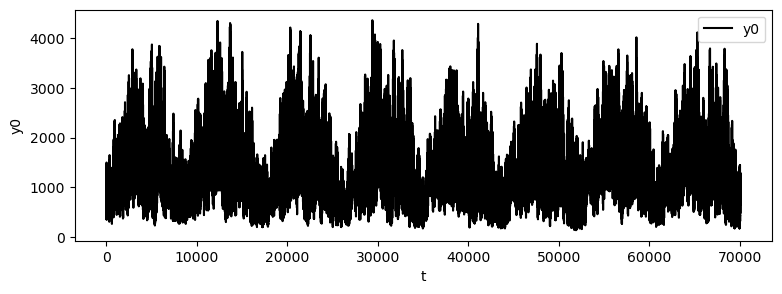

In [24]:
macro_data = H @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(9, int(3*macro_dim)))
for i in range(macro_dim):
    axs.plot(macro_data[:, i], "k", label=f"y{i}")
    axs.legend()
    axs.set(xlabel="t", ylabel=f"y{i}")
fig.show()

TypeError: 'Axes' object is not subscriptable

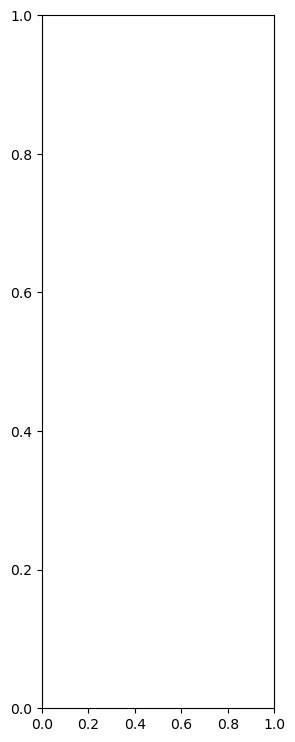

In [21]:
macro_data = H @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

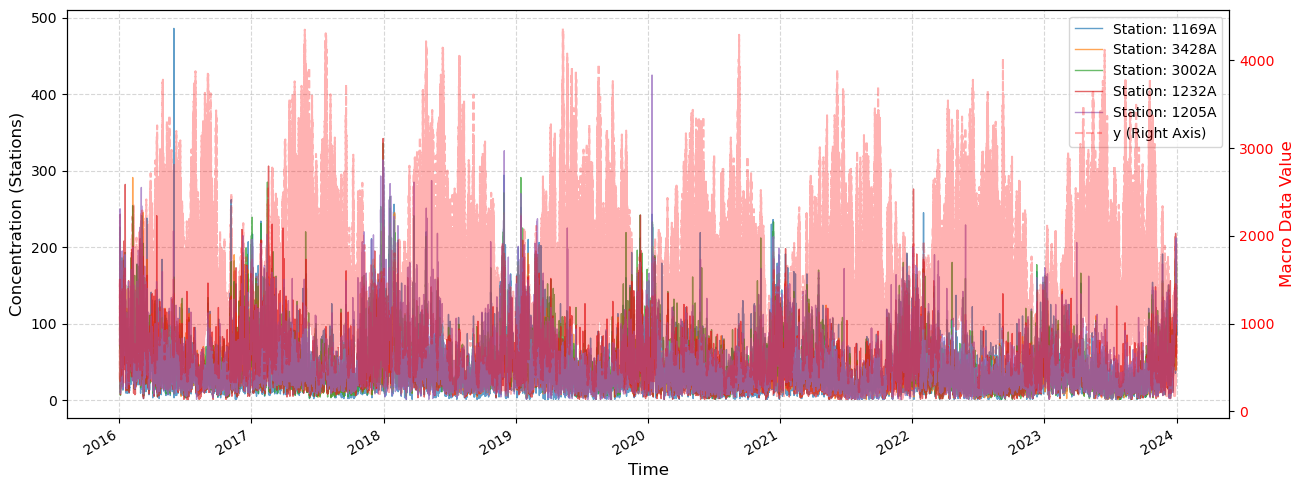

In [25]:
plot_macro_serie(pm25, macro_data[:, 0], n_delays, delay_interval, times, selected_indices, stations)

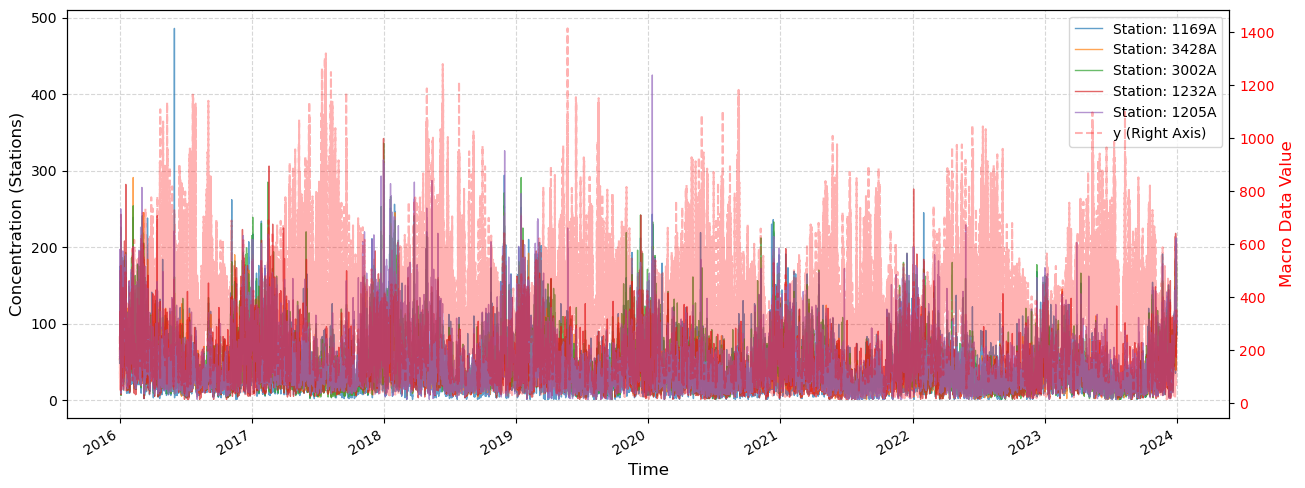

In [78]:
plot_macro_serie(pm25, macro_data[:, 1], n_delays, delay_interval, times, selected_indices, stations)

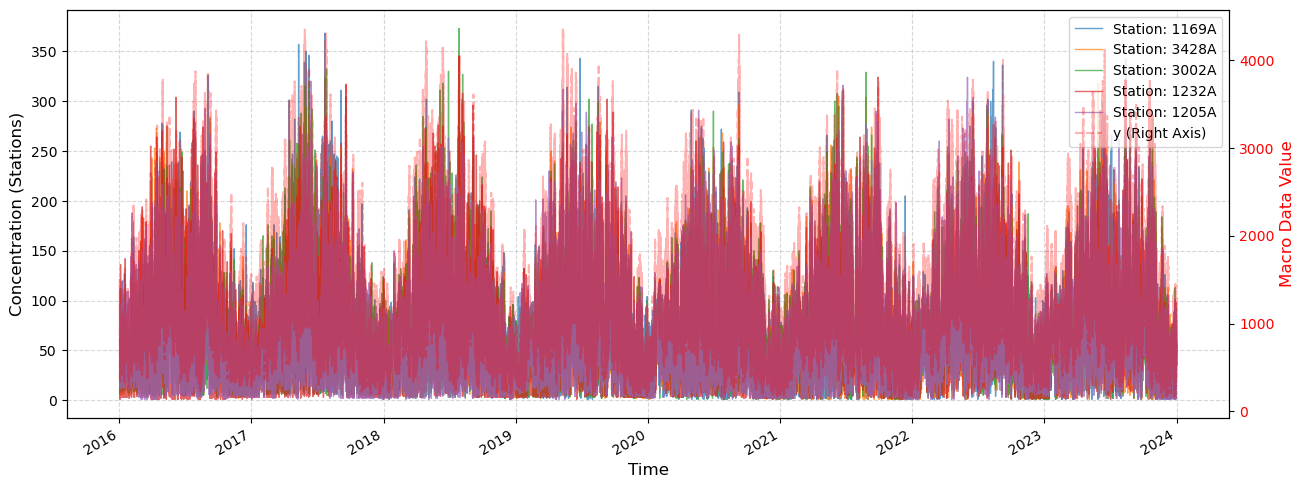

In [26]:
plot_macro_serie(o3, macro_data[:, 0], n_delays, delay_interval, times, selected_indices, stations)